# Infino - LangChain LLM Monitoring Example

This example shows how one can track the following while calling OpenAI models via LangChain:

* prompt input,
* response from chatgpt or any other LangChain model,
* latency,
* errors,
* number of tokens consumed

In [15]:
# Install necessary dependencies.
!pip install matplotlib
!pip install langchain
!pip install infinopy

import datetime as dt
from infinopy import InfinoClient
import json
from langchain.llms import OpenAI
import matplotlib.pyplot as plt
import matplotlib.dates as md
import os
import time
import sys

## Start Infino server, initialize the Infino client


In [16]:
# Start server using the Infino docker image.
!docker run --rm --detach --name infino-example -p 3000:3000 infinohq/infino:latest

# Create Infino client.
client = InfinoClient()

docker: Error response from daemon: Conflict. The container name "/infino-example" is already in use by container "e093e766798d38ddf04f75432d57f107eb768a306146c049feaec38be8c0fe28". You have to remove (or rename) that container to be able to reuse that name.
See 'docker run --help'.


## Read the questions dataset

In [17]:
# Read the questions. These are a subset of questions from Stanford's QA dataset - 
# https://rajpurkar.github.io/SQuAD-explorer/
fh = open("../datasets/stanford-qa-subset.txt")
lines = fh.readlines()
fh.close()

questions = []
for line in lines:
  if not line.startswith("#"):
    questions.append(line.strip())

## LangChain OpenAI Q&A; Publish metrics and logs to Infino

In [18]:
# Set your key here.
os.environ["OPENAI_API_KEY"] = "YOUR_API_KEY"

# Create LLM.
llm = OpenAI(temperature=0.1)

# Number of questions to ask the OpenAI model. We limit to a short number here to save $$ while running this demo.
num_questions = 10

questions = questions[0:num_questions]
question_id = 0
for question in questions:
    payload = {"date": int(time.time()), "prompt_question": question, "labels": {"id": question_id}}
    client.append_log(payload)
    
    start = time.time()
    print(question)

    is_error = 0
    try:
      # We send the question to OpenAI api and ask to limit to 2 sentences, mainly to save $$.
      llm_result = llm.generate([question])
      print(llm_result)
    except Exception as e:
      is_error = 1
      print("Error from OpenAI: ", e)

    end = time.time()
    duration = end-start
    payload = {"date": int(time.time()), "latency": duration, "labels": {"id": question_id}}
    client.append_ts(payload)
    
    payload = {"date": int(time.time()), "error": is_error, "labels": {"id": question_id}}
    client.append_ts(payload)

    if not is_error:
      generation = llm_result.generations[0][0]
      llm_output = llm_result.llm_output
      payload = {"date": int(time.time()), "prompt_response": generation.text, "labels": {"id": question_id}}
      print("Indexing payload", payload)
      client.append_log(payload)
      
      payload = {"date": int(time.time()), "prompt_tokens": llm_output['token_usage']['prompt_tokens'], "labels": {"id": question_id}}
      client.append_ts(payload)
      
      payload = {"date": int(time.time()), "completion_tokens": llm_output['token_usage']['completion_tokens'], "labels": {"id": question_id}}
      client.append_ts(payload)
      
      payload = {"date": int(time.time()), "total_tokens": llm_output['token_usage']['total_tokens'], "labels": {"id": question_id}}
      client.append_ts(payload)

    question_id += 1

In what country is Normandy located?
generations=[[Generation(text='\n\nNormandy is located in France.', generation_info={'finish_reason': 'stop', 'logprobs': None})]] llm_output={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 7, 'total_tokens': 16}, 'model_name': 'text-davinci-003'} run=RunInfo(run_id=UUID('ff70fe07-1b9e-4ad5-ac97-bdce76ffd0f0'))
Indexing payload {'date': 1686737134, 'prompt_response': '\n\nNormandy is located in France.', 'labels': {'id': 0}}
When were the Normans in Normandy?
generations=[[Generation(text='\n\nThe Normans first settled in Normandy in the late 9th century.', generation_info={'finish_reason': 'stop', 'logprobs': None})]] llm_output={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 8, 'total_tokens': 24}, 'model_name': 'text-davinci-003'} run=RunInfo(run_id=UUID('61a5c373-4e58-4c5d-8c0d-bc590fa4b8b5'))
Indexing payload {'date': 1686737136, 'prompt_response': '\n\nThe Normans first settled in Normandy in the late 9th century.', 'label

## Create Metric Charts

We now use matplotlib to create graphs of latency, errors and tokens consumed.

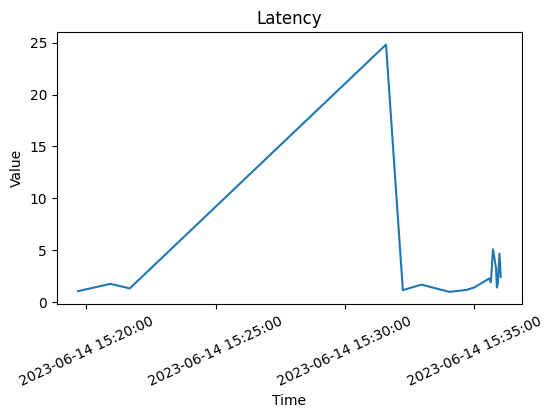

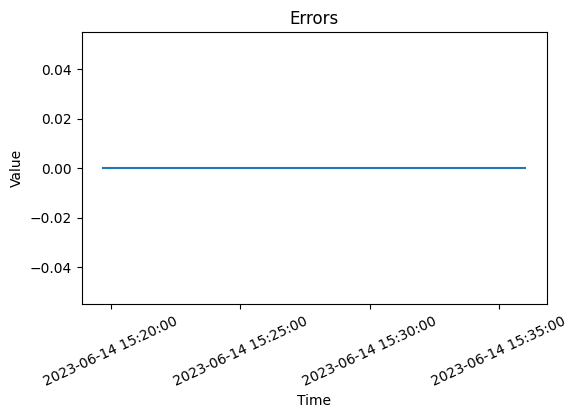

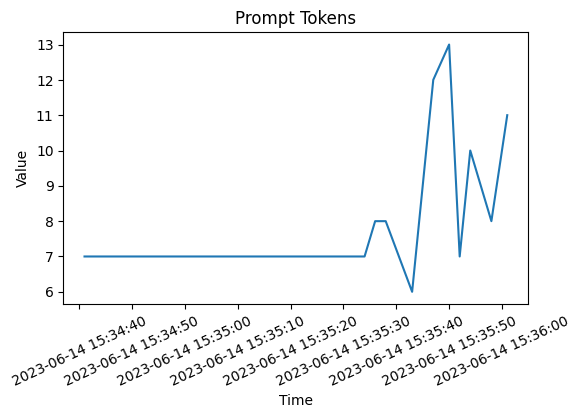

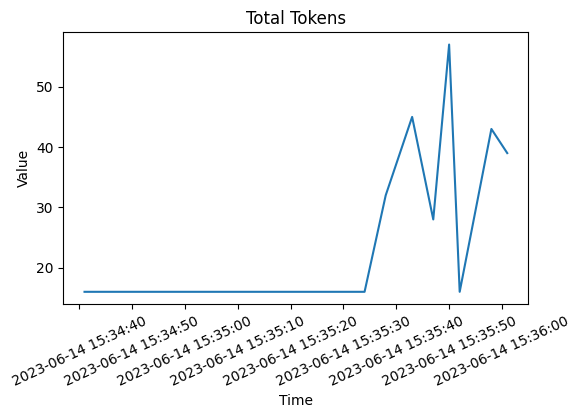

In [19]:
# Helper function to create a graph using matplotlib.
def plot(data, title):
  data = json.loads(data)

  # Extract x and y values from the data
  timestamps = [item["time"] for item in data]
  dates=[dt.datetime.fromtimestamp(ts) for ts in timestamps]
  y = [item["value"] for item in data]

  plt.rcParams['figure.figsize'] = [6, 4]
  plt.subplots_adjust(bottom=0.2)
  plt.xticks(rotation=25 )
  ax=plt.gca()
  xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
  ax.xaxis.set_major_formatter(xfmt)
  
  # Create the plot
  plt.plot(dates, y)

  # Set labels and title
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.title(title)

  plt.show()

response = client.search_ts("__name__", "latency", 0, int(time.time()))
plot(response.text, "Latency")

response = client.search_ts("__name__", "error", 0, int(time.time()))
plot(response.text, "Errors")

response = client.search_ts("__name__", "prompt_tokens", 0, int(time.time()))
plot(response.text, "Prompt Tokens")

response = client.search_ts("__name__", "total_tokens", 0, int(time.time()))
plot(response.text, "Total Tokens")


## Full text query on prompt or prompt outputs.

In [20]:
# Search for a particular prompt text.
query = "normandy"
response = client.search_log(query, 0, int(time.time()))
print("Results for", query, ":", response.text)

print("===")

query = "king charles III"
response = client.search_log("france.", 0, int(time.time()))
print("Results for", query, ":", response.text)


Results for normandy : [{"time":1686736180,"fields":{"prompt_question":"In what country is Normandy located?"},"text":"In what country is Normandy located?"},{"time":1686736255,"fields":{"prompt_question":"In what country is Normandy located?"},"text":"In what country is Normandy located?"},{"time":1686736300,"fields":{"prompt_question":"In what country is Normandy located?"},"text":"In what country is Normandy located?"},{"time":1686736870,"fields":{"prompt_question":"In what country is Normandy located?"},"text":"In what country is Normandy located?"},{"time":1686736933,"fields":{"prompt_question":"In what country is Normandy located?"},"text":"In what country is Normandy located?"},{"time":1686736975,"fields":{"prompt_question":"In what country is Normandy located?"},"text":"In what country is Normandy located?"},{"time":1686737041,"fields":{"prompt_question":"In what country is Normandy located?"},"text":"In what country is Normandy located?"},{"time":1686737042,"fields":{"prompt_r

## Step 5: Stop infino server

In [21]:
!docker rm -f infino-example

infino-example
